In [1]:
import os
os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = "false"
import sys
sys.path.append('../experiments')

import matplotlib.pyplot as plt
import numpy as np
from jax import random
import jax
import jax.numpy as jnp


from tracr.rasp import rasp

from rasp_tokenizer import tokenizer, vocab
from rasp_tokenizer import MAX_WEIGHTS_LENGTH
import rasp_tokenizer.lib

from rasp_generator import utils as gen_utils

from load_checkpoint import get_model, get_data

from metamodels_for_rasp.model import TransformerConfig, Transformer

In [2]:
rng = random.PRNGKey(0)

2024-02-01 21:09:20.596100: W external/xla/xla/service/gpu/nvptx_compiler.cc:698] The NVIDIA driver's CUDA version is 12.2 which is older than the ptxas CUDA version (12.3.107). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


In [3]:
base_checkpoint_path = "/home/lauro/projects/meta-models/metamodels-for-rasp/outputs/mm-checkpoints/decompile/"
! ls $base_checkpoint_path

comic-brook-145     info.json		  run_1706711440
efficient-dawn-146  northern-morning-140  visionary-moon-132


In [4]:
# checkpoint_name = "northern-morning-140"
# checkpoint_name = "efficient-dawn-146"
checkpoint_name = "apricot-monkey-147"

checkpointpath = base_checkpoint_path + checkpoint_name

In [5]:
model, params = get_model(checkpointpath)

In [6]:
print(model.config.weight_len)
print(model.config.rasp_tok_len)
print(model.config.emb_dim)
print(model.config.decode)
rasp_tok_len = model.config.rasp_tok_len
weight_len = model.config.weight_len

64
32
128
False


In [7]:
bs = 5
empty_batch = {
    "weights": np.ones((bs, model.config.weight_len, model.config.emb_dim)),
    "rasp_tok": np.zeros((bs, model.config.rasp_tok_len)).astype(int),
}


dummy_data = {
    "weights": np.ones((bs, model.config.weight_len, model.config.emb_dim)),
    "rasp_tok": np.ones((bs, model.config.rasp_tok_len)),
}

In [8]:
data, seq_len = get_data(model.config.emb_dim, ["lib"])
data = data['lib']
print(seq_len)
print(data.keys())
print(data['weights'].shape)
print(data['rasp_tok'].shape)

2024-02-01 21:09:21 [INFO]: Loading data from /home/lauro/projects/meta-models/rasp-generator/data/deduped/lib.
96
dict_keys(['rasp_tok', 'weights', 'program_id', 'n_sops', 'n_layers'])
(18, 64, 128)
(18, 32)


In [9]:
def forward(params: dict, batch: dict):
    out = model.apply(
        {'params': params},
        {k: v for k, v in batch.items()},
        is_training=False,
        rngs={'dropout': rng},
    )

    logits = out[:, weight_len-1:-1, :]
    return logits


def get_next_pred(params: dict, batch: dict, i: int):
    """Get temperature=0 prediction for next token at
    position i in the sequence (not counting weights)."""
    logits = forward(params, batch)
    next_logits = logits[:, i, :]
    preds = next_logits.argmax(axis=-1).astype(np.int32)
    return preds


def decode(batch: dict):
    """Autoregressively decode the batch."""
    output = {
        "weights": batch["weights"],
        "rasp_tok": np.zeros(batch['rasp_tok'].shape).astype(int),
    }
    for i in range(0, rasp_tok_len):
        if i == 0:
            output['rasp_tok'][:, i] = vocab.bos_id
        output['rasp_tok'][:, i] = get_next_pred(params, output, i)
    
    output = output['rasp_tok']
    return output

In [10]:
output = decode(data)
print("program ids:", data['program_id'])

program ids: [0 0 1 1 1 1 2 2 2 2 2 2 2 2 3 3 3 3]


In [11]:
def print_reconstruction(program_id: int, output: np.ndarray, print_true=False):
    idxs = data['program_id'] == program_id
    for x in output[idxs]:
        d = tokenizer.decode(x)
        print(d[:d.index("EOS")+1])

    if print_true: 
        print()
        print("True:")
        for x in data['rasp_tok'][idxs]:
            d = tokenizer.decode(x)
            print(d[:d.index("EOS")+1])

In [12]:
def get_acc(program_id: int, output: np.ndarray):
    truncated_outputs = []
    for x in output[data['program_id'] == program_id]:
        eos_id = np.nonzero(x == vocab.eos_id)[0][0]
        truncated_outputs.append(x[:eos_id+1])
    truncated_outputs = np.concatenate(truncated_outputs[1:])  # skip BOS token
    return truncated_outputs.mean()

## Programs

In [13]:
idx = 0
# ground truth
program = rasp_tokenizer.lib.examples[idx]
gen_utils.print_program(program)
print()

# reconstruction
print_reconstruction(idx, output, print_true=True)
get_acc(idx, output)

select_2 = Select(tokens, tokens, predicate=Comparison.TRUE)
selector_width_1 = SelectorWidth(select_2)    # type: Encoding.CATEGORICAL

['BOS', 'Selector_0', 'Select', 'TRUE', 'SOp_4', 'SOp_2', 'SEP', 'SOp_0', 'numerical', 'Aggregate', 'Selector_0', 'SOp_3', 'EOS']
['BOS', 'EOS']

True:
['BOS', 'Selector_0', 'Select', 'TRUE', 'SOp_1', 'SOp_1', 'SEP', 'SOp_0', 'categorical', 'SelectorWidth', 'Selector_0', 'EOS']
['BOS', 'EOS']


1.5

In [14]:
idx = 1
# ground truth
program = rasp_tokenizer.lib.examples[idx]
gen_utils.print_program(program)
print()

# reconstruction
print_reconstruction(idx, output, print_true=True)
get_acc(idx, output)

select_6 = Select(tokens, tokens, predicate=Comparison.LT)
selector_width_5 = SelectorWidth(select_6)    # type: Encoding.CATEGORICAL
select_4 = Select(selector_width_5, indices, predicate=Comparison.EQ)
aggregate_3 = Aggregate(select_4, tokens)    # type: Encoding.CATEGORICAL

['BOS', 'Selector_0', 'Select', 'LT', 'SOp_7', 'SOp_7', 'SEP', 'SOp_6', 'categorical', 'SelectorWidth', 'Selector_0', 'EOS']
['BOS', 'EOS']
['BOS', 'Selector_0', 'Select', 'EQ', 'SOp_2', 'SOp_2', 'SEP', 'SOp_0', 'categorical', 'Aggregate', 'Selector_0', 'SOp_3', 'EOS']
['BOS', 'EOS']

True:
['BOS', 'Selector_1', 'Select', 'LT', 'SOp_3', 'SOp_3', 'SEP', 'SOp_2', 'categorical', 'SelectorWidth', 'Selector_1', 'EOS']
['BOS', 'EOS']
['BOS', 'Selector_0', 'Select', 'EQ', 'SOp_2', 'SOp_1', 'SEP', 'SOp_0', 'categorical', 'Aggregate', 'Selector_0', 'SOp_3', 'EOS']
['BOS', 'EOS']


22.235294117647058

In [15]:
# # predicted:
# sel0 = Select(sop7, sop7, LT)
# sop6 = SelectorWidth(sel0)
# sel0 = Select(sop2, sop2, EQ)
# sop0 = Aggregate(sel0, sop3)
# 
# # vs true:
# sel1 = Select(sop3, sop3, LT)
# sop2 = SelectorWidth(sel1)
# sel0 = Select(sop2, sop1, EQ)
# sop0 = Aggregate(sel0, sop3)

NameError: name 'Select' is not defined

### empty MLP layer has stuff in it - why?

In [ ]:
attn_1 = data['weights'][data['program_id'] == 1][0]
empty_mlp = data['weights'][data['program_id'] == 1][1]

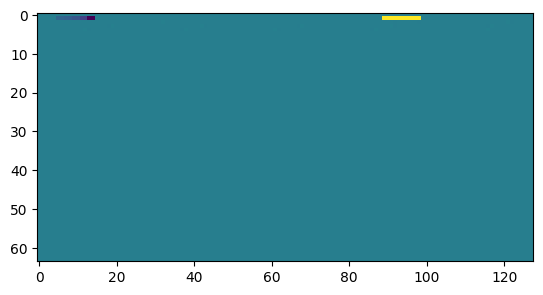

In [ ]:
plt.imshow(empty_mlp)

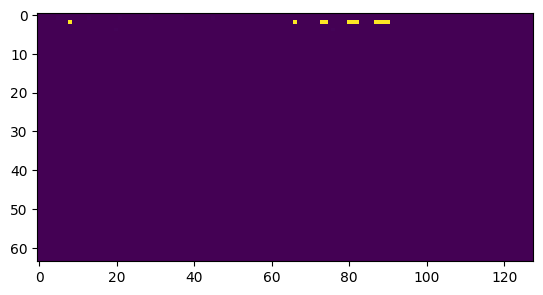

In [ ]:
plt.imshow(attn_1)

In [ ]:
values, counts = np.unique(empty_mlp, return_counts=True)

In [ ]:
values

array([-2.8237953e+01, -2.7861446e+01, -1.5687752e+01, -1.5311246e+01,
       -1.0981426e+01, -1.0604919e+01, -8.4713860e+00, -8.0948801e+00,
       -6.9026108e+00, -6.5261049e+00, -3.7650603e-01,  0.0000000e+00,
        1.8825302e-02,  3.7650603e-01,  3.7650604e+01], dtype=float32)

In [ ]:
counts

array([   1,    1,    1,    1,    1,    1,    1,    1,    1,    1,   12,
        592, 7555,   13,   10])

In [ ]:
s = Select(sop2, sop2, LEQ)
sop1 = Aggregate()

NameError: name 'Select' is not defined

In [ ]:
from tracr.compiler import compiling

In [ ]:
p = rasp_tokenizer.lib.examples[1]
model = compiling.compile_rasp_to_model(p, vocab={0,1,2,3,4}, max_seq_len=5)

In [ ]:
jax.tree_map(lambda x: x.shape, model.params)

{'pos_embed': {'embeddings': (6, 25)},
 'token_embed': {'embeddings': (7, 25)},
 'transformer/layer_0/attn/key': {'b': (7,), 'w': (25, 7)},
 'transformer/layer_0/attn/linear': {'b': (25,), 'w': (7, 25)},
 'transformer/layer_0/attn/query': {'b': (7,), 'w': (25, 7)},
 'transformer/layer_0/attn/value': {'b': (7,), 'w': (25, 7)},
 'transformer/layer_0/mlp/linear_1': {'b': (12,), 'w': (25, 12)},
 'transformer/layer_0/mlp/linear_2': {'b': (25,), 'w': (12, 25)},
 'transformer/layer_1/attn/key': {'b': (7,), 'w': (25, 7)},
 'transformer/layer_1/attn/linear': {'b': (25,), 'w': (7, 25)},
 'transformer/layer_1/attn/query': {'b': (7,), 'w': (25, 7)},
 'transformer/layer_1/attn/value': {'b': (7,), 'w': (25, 7)},
 'transformer/layer_1/mlp/linear_1': {'b': (12,), 'w': (25, 12)},
 'transformer/layer_1/mlp/linear_2': {'b': (25,), 'w': (12, 25)}}

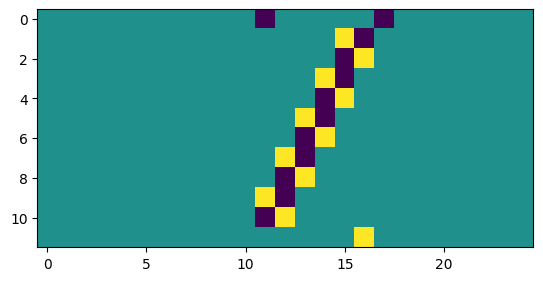

In [ ]:
plt.imshow(model.params['transformer/layer_0/mlp/linear_2']['w'])

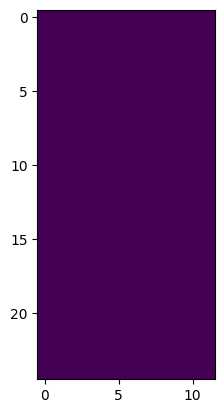

In [ ]:
plt.imshow(model.params['transformer/layer_1/mlp/linear_1']['w'])